In [1]:
import torch
import math
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt
import os   
from torch.nn.init import xavier_normal_, xavier_normal
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [2]:
def generate_disc_set(nb):
    # creating the circle in the middle of the points
    axis = torch.FloatTensor(1,2).uniform_(0.5,0.5)
    r = 1/((2*math.pi)**0.5)
    
    train_input   =  torch.FloatTensor(nb, 2).uniform_(0,1)
    train_target  =  torch.FloatTensor(nb, 2)
    train_mask    =  torch.FloatTensor(nb, 1)
    test_input    =  torch.FloatTensor(nb, 2).uniform_(0,1)
    test_target   =  torch.FloatTensor(nb, 2)
    test_mask     =  torch.FloatTensor(nb, 1)
    
    for i in range(0, len(train_input)):
        a = abs((train_input[i] - axis).pow(2).sum(1).view(-1).pow(0.5))
        b = abs((test_input[i]  - axis).pow(2).sum(1).view(-1).pow(0.5))
    
        if a < r:
            train_target[i][0] = 0
            train_target[i][1] = 1
            train_mask[i]      = 1
        else:
            train_target[i][0] = 1
            train_target[i][1] = 0
            train_mask[i]      = 0
            
        if b < r:
            test_target[i][0] = 0
            test_target[i][1] = 1
            test_mask[i]      = 1
        else:
            test_target[i][0] = 1
            test_target[i][1] = 0
            test_mask[i]      = 0
        
    return train_input, train_target, test_input, test_target, test_mask, train_mask

In [3]:
train_input, train_target, test_input, test_target, test_mask, train_mask = generate_disc_set(1000)

In [4]:
train_scatter = torch.cat((train_input, train_mask),1)
train_scatter_false = train_scatter[train_scatter[:,2] == 0]
train_scatter_true = train_scatter[train_scatter[:,2] == 1]

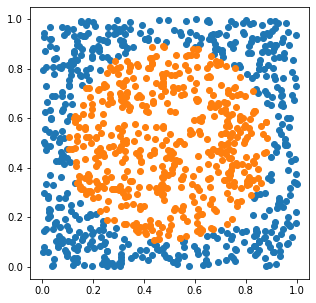

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(train_scatter_false[:,0], train_scatter_false[:,1], )
plt.scatter(train_scatter_true[:,0], train_scatter_true[:,1], )

In [6]:
def ReLu(x):
    return x.clamp(min=0)

def dReLu(x):
    return (torch.sign(x) + 1)/2

In [7]:
def loss(v, t):
    return (v - t).pow(2).sum()

def dloss(v, t):
    return 2 * (v - t)

In [8]:
def sigma(x):
    return x.tanh()

def dsigma(x):
    return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)

In [35]:
def forward_pass(w1, b1, w2, b2,w3, b3,  x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = ReLu(s1)
    s2 = w2.mv(x1) + b2
    x2 = ReLu(s2)
    s3 = w3.mv(x2) + b3
    x3 = ReLu(s3)

    return x0, s1, x1, s2, x2, s3, x3

In [21]:
def forward_pass(w1, b1, w2, b2,w3, b3,  x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = ReLu(s1)
    s2 = w2.mv(x1) + b2
    x2 = ReLu(s2)
    s3 = w3.mv(x2) + b3
    x3 = ReLu(s3)

    return x0, s1, x1, s2, x2, s3, x3

def backward_pass(w1, b1, w2, b2, w3, b3,
                  t,
                  x, s1, x1, s2, x2, s3, x3,
                  dl_dw1, dl_db1, dl_dw2, dl_db2,dl_dw3,dl_db3):
    x0 = x
    dl_dx3 = dloss(x3, t)
    dl_ds3 = dReLu(s3) * dl_dx3
    
    dl_dx2 = w3.t().mv(dl_ds3)
    dl_ds2 = dReLu(s2) * dl_dx2
    
    dl_dx1 = w2.t().mv(dl_ds2)
    dl_ds1 = dReLu(s1) * dl_dx1
    
    
    dl_dw3.add_(dl_ds3.view(-1, 1).mm(x2.view(1, -1)))
    dl_db3.add_(dl_ds3) 

    dl_dw2.add_(dl_ds2.view(-1, 1).mm(x1.view(1, -1)))
    dl_db2.add_(dl_ds2)
    
    dl_dw1.add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_db1.add_(dl_ds1)

######################################################################

nb_classes = train_target.size(1)
nb_train_samples = train_input.size(0)

zeta = 1

train_target = train_target * zeta
test_target = test_target * zeta

nb_hidden = 25
eta = 0.0005
epsilon = 1e-3

#SGD momentum
momentum = 0.999

#weights and biases
w1 = xavier_normal_(torch.empty(nb_hidden, train_input.size(1)).normal_(0, epsilon))
b1 = torch.empty(nb_hidden).normal_(0, epsilon)

w2 = xavier_normal_(torch.empty(nb_hidden, nb_hidden).normal_(0, epsilon))
b2 = torch.empty(nb_hidden).normal_(0, epsilon)

w3 = xavier_normal_(torch.empty(nb_classes, nb_hidden).normal_(0, epsilon))
b3 = torch.empty(nb_classes).normal_(0, epsilon)


#Gradient
dl_dw1 = torch.empty(w1.size())
dl_db1 = torch.empty(b1.size())

dl_dw2 = torch.empty(w2.size())
dl_db2 = torch.empty(b2.size())

dl_dw3 = torch.empty(w3.size())
dl_db3 = torch.empty(b3.size())


# SGD velocities
velocity_w1 = torch.empty(w1.size())
velocity_b1 = torch.empty(b1.size())

velocity_w2 = torch.empty(w2.size())
velocity_b2 = torch.empty(b2.size())

velocity_w3 = torch.empty(w3.size())
velocity_b3 = torch.empty(b3.size())







for k in range(2000):

    # Back-prop

    acc_loss = 0
    nb_train_errors = 0

    dl_dw1.zero_()
    dl_db1.zero_()
    
    dl_dw2.zero_()
    dl_db2.zero_()
    
    dl_dw3.zero_()
    dl_db3.zero_()

    for n in range(nb_train_samples):
        x0, s1, x1, s2, x2, s3, x3 = forward_pass(w1, b1, w2, b2, w3, b3, train_input[n])

        
        pred = x3.max(0)[1].item()
        target = 0
        if train_target[n][0] == 0 : target = 1
        if target != pred : nb_train_errors = nb_train_errors + 1
        acc_loss = acc_loss + loss(x3, train_target[n])
        

        backward_pass(w1, b1, w2, b2,w3,b3,
                      train_target[n],
                      x0, s1, x1, s2, x2,s3,x3,
                      dl_dw1, dl_db1, dl_dw2, dl_db2,dl_dw3,dl_db3)

    # SGD
    
    #velocity_w1 = momentum * velocity_w1 - eta * dl_dw1
    #w1 = w1 + velocity_w1
    
    #velocity_b1 = momentum * velocity_b1 - eta * dl_db1
    #b1 = b1 + velocity_b1
    
    
    #velocity_w2 = momentum * velocity_w2 - eta * dl_dw2
    #w2 = w2 + velocity_w2
    
    #velocity_b2 = momentum * velocity_b2 - eta * dl_db2
    #b2 = b2 + velocity_b2
    
    
    #velocity_w3 = momentum * velocity_w3 - eta * dl_dw3
    #w3 = w3 + velocity_w3
    
    #velocity_b3 = momentum * velocity_b3 - eta * dl_db3
    #b3 = b3 + velocity_b3
    
    
    #### SGD towerds data science
    #velocity_w1 = momentum * velocity_w1 + dl_dw1
    #w1 = w1 - eta * velocity_w1
    
    #velocity_b1 = momentum * velocity_b1 + dl_db1
    #b1 = b1 - eta * velocity_b1 
    
    
    #velocity_w2 = momentum * velocity_w2 + dl_dw2
    #w2 = w2 - eta * velocity_w2
    
    #velocity_b2 = momentum * velocity_b2 + dl_db2
    #b2 = b2 - eta * velocity_b2 
    
    
    #velocity_w3 = momentum * velocity_w3 + dl_dw3
    #w3 = w3 - eta * velocity_w3
    
    #velocity_b3 = momentum * velocity_b3 + dl_db3
    #b3 = b3 - eta * velocity_b3 
    

    ## Normal gradient step
    #if momentum != 1:
        #momentum = momentum + 0.01
        
    eta = eta * momentum
    print(eta)
    
    
    
    w1 = w1 - eta * dl_dw1
    b1 = b1 - eta * dl_db1
    
    w2 = w2 - eta * dl_dw2
    b2 = b2 - eta * dl_db2
    
    w3 = w3 - eta * dl_dw3
    b3 = b3 - eta * dl_db3
    
    
    
    
    

    # Test error

    nb_test_errors = 0

    for n in range(test_input.size(0)):
        _, _, _, _,_,_, x3 = forward_pass(w1, b1, w2, b2,w3,b3, test_input[n])

        pred = x3.max(0)[1].item()
        target = 0
        if test_target[n][0] == 0 : target = 1
        if target != pred : nb_test_errors = nb_test_errors + 1

    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(k,
                  acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))

0.0004995
0 acc_train_loss 967.01 acc_train_error 47.60% test_error 48.40%
0.0004990005
1 acc_train_loss 677.89 acc_train_error 50.90% test_error 51.60%
0.0004985014995
2 acc_train_loss 912.37 acc_train_error 49.10% test_error 51.60%
0.0004980029980005
3 acc_train_loss 548.58 acc_train_error 49.10% test_error 40.30%
0.0004975049950024995
4 acc_train_loss 492.28 acc_train_error 42.10% test_error 54.60%
0.000497007490007497
5 acc_train_loss 483.47 acc_train_error 52.30% test_error 32.20%
0.0004965104825174894
6 acc_train_loss 477.90 acc_train_error 34.80% test_error 35.10%
0.0004960139720349719
7 acc_train_loss 474.36 acc_train_error 36.80% test_error 33.80%
0.0004955179580629369
8 acc_train_loss 471.32 acc_train_error 36.50% test_error 34.10%
0.000495022440104874
9 acc_train_loss 468.56 acc_train_error 37.20% test_error 33.60%
0.0004945274176647691
10 acc_train_loss 465.97 acc_train_error 36.30% test_error 33.60%
0.0004940328902471044
11 acc_train_loss 463.34 acc_train_error 37.00% test

0.00045466485573132946
94 acc_train_loss 432.88 acc_train_error 39.10% test_error 36.10%
0.0004542101908755981
95 acc_train_loss 398.43 acc_train_error 35.00% test_error 35.30%
0.0004537559806847225
96 acc_train_loss 426.49 acc_train_error 38.40% test_error 35.30%
0.0004533022247040378
97 acc_train_loss 391.42 acc_train_error 34.00% test_error 34.80%
0.00045284892247933375
98 acc_train_loss 420.38 acc_train_error 37.70% test_error 34.40%
0.00045239607355685444
99 acc_train_loss 387.15 acc_train_error 33.10% test_error 34.60%
0.0004519436774832976
100 acc_train_loss 418.29 acc_train_error 37.00% test_error 34.30%
0.0004514917338058143
101 acc_train_loss 385.78 acc_train_error 33.10% test_error 34.90%
0.0004510402420720085
102 acc_train_loss 420.28 acc_train_error 37.50% test_error 34.50%
0.0004505892018299365
103 acc_train_loss 386.35 acc_train_error 33.30% test_error 35.00%
0.00045013861262810655
104 acc_train_loss 419.99 acc_train_error 37.50% test_error 34.50%
0.00044968847401547846


0.00041468306764278986
186 acc_train_loss 326.43 acc_train_error 27.80% test_error 24.20%
0.0004142683845751471
187 acc_train_loss 266.24 acc_train_error 21.20% test_error 23.60%
0.00041385411619057193
188 acc_train_loss 279.61 acc_train_error 23.60% test_error 23.10%
0.00041344026207438135
189 acc_train_loss 255.47 acc_train_error 20.50% test_error 23.70%
0.00041302682181230694
190 acc_train_loss 286.37 acc_train_error 23.60% test_error 23.60%
0.00041261379499049465
191 acc_train_loss 267.88 acc_train_error 21.10% test_error 24.90%
0.00041220118119550414
192 acc_train_loss 317.40 acc_train_error 24.60% test_error 22.40%
0.00041178898001430865
193 acc_train_loss 264.78 acc_train_error 21.00% test_error 22.80%
0.00041137719103429433
194 acc_train_loss 302.17 acc_train_error 21.90% test_error 20.30%
0.00041096581384326004
195 acc_train_loss 230.03 acc_train_error 17.40% test_error 19.10%
0.0004105548480294168
196 acc_train_loss 249.48 acc_train_error 18.00% test_error 18.50%
0.0004101442

0.0003782171514291189
278 acc_train_loss 197.41 acc_train_error 13.30% test_error 14.40%
0.0003778389342776898
279 acc_train_loss 166.51 acc_train_error 10.10% test_error 12.40%
0.0003774610953434121
280 acc_train_loss 195.85 acc_train_error 14.00% test_error 14.80%
0.0003770836342480687
281 acc_train_loss 168.21 acc_train_error 9.90% test_error 13.50%
0.00037670655061382063
282 acc_train_loss 197.63 acc_train_error 15.20% test_error 14.60%
0.0003763298440632068
283 acc_train_loss 175.73 acc_train_error 11.70% test_error 14.10%
0.0003759535142191436
284 acc_train_loss 200.03 acc_train_error 16.40% test_error 17.30%
0.0003755775607049245
285 acc_train_loss 193.23 acc_train_error 13.50% test_error 13.90%
0.00037520198314421955
286 acc_train_loss 195.92 acc_train_error 16.00% test_error 17.80%
0.0003748267811610753
287 acc_train_loss 200.44 acc_train_error 13.80% test_error 12.60%
0.0003744519543799142
288 acc_train_loss 183.25 acc_train_error 14.30% test_error 16.80%
0.000374077502425534

0.0003446129745153255
371 acc_train_loss 161.04 acc_train_error 11.60% test_error 13.10%
0.00034426836154081015
372 acc_train_loss 175.52 acc_train_error 12.50% test_error 13.70%
0.0003439240931792693
373 acc_train_loss 161.30 acc_train_error 11.70% test_error 12.50%
0.00034358016908609003
374 acc_train_loss 172.54 acc_train_error 12.30% test_error 12.80%
0.00034323658891700394
375 acc_train_loss 157.70 acc_train_error 11.20% test_error 11.90%
0.00034289335232808694
376 acc_train_loss 165.88 acc_train_error 11.90% test_error 12.30%
0.0003425504589757588
377 acc_train_loss 152.58 acc_train_error 10.60% test_error 11.40%
0.00034220790851678304
378 acc_train_loss 159.53 acc_train_error 10.80% test_error 12.00%
0.00034186570060826623
379 acc_train_loss 148.12 acc_train_error 10.10% test_error 10.70%
0.00034152383490765797
380 acc_train_loss 154.28 acc_train_error 10.10% test_error 11.50%
0.00034118231107275034
381 acc_train_loss 144.35 acc_train_error 9.80% test_error 10.50%
0.000340841128

0.0003136804971794889
465 acc_train_loss 114.23 acc_train_error 6.60% test_error 6.80%
0.00031336681668230943
466 acc_train_loss 118.28 acc_train_error 6.60% test_error 9.40%
0.0003130534498656271
467 acc_train_loss 113.99 acc_train_error 6.50% test_error 6.60%
0.0003127403964157615
468 acc_train_loss 118.39 acc_train_error 6.50% test_error 9.40%
0.0003124276560193457
469 acc_train_loss 113.55 acc_train_error 6.30% test_error 6.70%
0.00031211522836332637
470 acc_train_loss 118.32 acc_train_error 6.30% test_error 9.30%
0.000311803113134963
471 acc_train_loss 112.73 acc_train_error 6.00% test_error 6.70%
0.00031149131002182804
472 acc_train_loss 117.68 acc_train_error 5.90% test_error 9.20%
0.0003111798187118062
473 acc_train_loss 111.68 acc_train_error 5.60% test_error 6.80%
0.0003108686388930944
474 acc_train_loss 116.52 acc_train_error 5.80% test_error 9.10%
0.00031055777025420134
475 acc_train_loss 110.40 acc_train_error 5.20% test_error 6.70%
0.00031024721248394714
476 acc_train_los

0.0002852389959916881
560 acc_train_loss 93.06 acc_train_error 3.90% test_error 6.30%
0.0002849537569956964
561 acc_train_loss 92.17 acc_train_error 4.30% test_error 3.70%
0.00028466880323870067
562 acc_train_loss 92.87 acc_train_error 3.80% test_error 6.20%
0.000284384134435462
563 acc_train_loss 91.99 acc_train_error 4.20% test_error 3.60%
0.00028409975030102655
564 acc_train_loss 92.92 acc_train_error 3.70% test_error 6.50%
0.0002838156505507255
565 acc_train_loss 92.04 acc_train_error 4.30% test_error 3.80%
0.00028353183490017477
566 acc_train_loss 93.17 acc_train_error 3.80% test_error 6.70%
0.0002832483030652746
567 acc_train_loss 92.04 acc_train_error 4.10% test_error 3.70%
0.0002829650547622093
568 acc_train_loss 93.31 acc_train_error 3.50% test_error 6.60%
0.00028268208970744707
569 acc_train_loss 92.10 acc_train_error 4.00% test_error 4.00%
0.0002823994076177396
570 acc_train_loss 93.33 acc_train_error 3.70% test_error 6.70%
0.00028211700821012184
571 acc_train_loss 91.85 acc

0.00025937629392302006
655 acc_train_loss 79.86 acc_train_error 3.00% test_error 2.90%
0.00025911691762909705
656 acc_train_loss 80.16 acc_train_error 2.60% test_error 4.60%
0.000258857800711468
657 acc_train_loss 79.51 acc_train_error 2.90% test_error 2.90%
0.0002585989429107565
658 acc_train_loss 79.80 acc_train_error 2.50% test_error 4.50%
0.0002583403439678457
659 acc_train_loss 79.14 acc_train_error 2.70% test_error 2.80%
0.00025808200362387786
660 acc_train_loss 79.32 acc_train_error 2.50% test_error 4.20%
0.000257823921620254
661 acc_train_loss 78.66 acc_train_error 2.70% test_error 2.50%
0.0002575660976986337
662 acc_train_loss 78.79 acc_train_error 2.40% test_error 4.10%
0.0002573085316009351
663 acc_train_loss 78.10 acc_train_error 2.60% test_error 2.30%
0.00025705122306933417
664 acc_train_loss 78.15 acc_train_error 2.30% test_error 4.00%
0.00025679417184626483
665 acc_train_loss 77.63 acc_train_error 2.60% test_error 2.00%
0.0002565373776744186
666 acc_train_loss 77.67 acc_

0.0002358585705132737
750 acc_train_loss 69.91 acc_train_error 1.20% test_error 2.20%
0.00023562271194276042
751 acc_train_loss 69.88 acc_train_error 1.60% test_error 1.20%
0.00023538708923081766
752 acc_train_loss 69.86 acc_train_error 1.20% test_error 2.30%
0.00023515170214158683
753 acc_train_loss 69.81 acc_train_error 1.60% test_error 1.20%
0.00023491655043944524
754 acc_train_loss 69.78 acc_train_error 1.20% test_error 2.40%
0.0002346816338890058
755 acc_train_loss 69.71 acc_train_error 1.60% test_error 1.30%
0.0002344469522551168
756 acc_train_loss 69.70 acc_train_error 1.20% test_error 2.40%
0.00023421250530286167
757 acc_train_loss 69.63 acc_train_error 1.60% test_error 1.30%
0.00023397829279755882
758 acc_train_loss 69.61 acc_train_error 1.20% test_error 2.30%
0.00023374431450476127
759 acc_train_loss 69.54 acc_train_error 1.60% test_error 1.30%
0.0002335105701902565
760 acc_train_loss 69.51 acc_train_error 1.20% test_error 2.30%
0.00023327705962006626
761 acc_train_loss 69.43

0.00021447320587083044
845 acc_train_loss 65.80 acc_train_error 1.20% test_error 1.50%
0.00021425873266495962
846 acc_train_loss 65.76 acc_train_error 1.10% test_error 1.80%
0.00021404447393229465
847 acc_train_loss 65.73 acc_train_error 1.20% test_error 1.60%
0.00021383042945836235
848 acc_train_loss 65.70 acc_train_error 1.10% test_error 1.80%
0.00021361659902890398
849 acc_train_loss 65.66 acc_train_error 1.20% test_error 1.60%
0.00021340298242987507
850 acc_train_loss 65.62 acc_train_error 1.10% test_error 1.80%
0.0002131895794474452
851 acc_train_loss 65.58 acc_train_error 1.20% test_error 1.70%
0.00021297638986799775
852 acc_train_loss 65.53 acc_train_error 1.10% test_error 1.80%
0.00021276341347812976
853 acc_train_loss 65.50 acc_train_error 1.10% test_error 1.70%
0.00021255065006465162
854 acc_train_loss 65.46 acc_train_error 1.10% test_error 1.80%
0.00021233809941458698
855 acc_train_loss 65.43 acc_train_error 1.20% test_error 1.70%
0.00021212576131517238
856 acc_train_loss 65

0.00019502685841099368
940 acc_train_loss 62.95 acc_train_error 1.10% test_error 1.80%
0.0001948318315525827
941 acc_train_loss 62.93 acc_train_error 1.30% test_error 1.50%
0.00019463699972103012
942 acc_train_loss 62.91 acc_train_error 1.10% test_error 2.00%
0.0001944423627213091
943 acc_train_loss 62.89 acc_train_error 1.30% test_error 1.50%
0.00019424792035858778
944 acc_train_loss 62.88 acc_train_error 1.10% test_error 2.00%
0.0001940536724382292
945 acc_train_loss 62.84 acc_train_error 1.30% test_error 1.60%
0.00019385961876579097
946 acc_train_loss 62.81 acc_train_error 1.10% test_error 1.90%
0.00019366575914702517
947 acc_train_loss 62.77 acc_train_error 1.30% test_error 1.60%
0.00019347209338787814
948 acc_train_loss 62.72 acc_train_error 1.10% test_error 1.90%
0.00019327862129449026
949 acc_train_loss 62.68 acc_train_error 1.30% test_error 1.60%
0.00019308534267319577
950 acc_train_loss 62.65 acc_train_error 1.10% test_error 1.90%
0.00019289225733052257
951 acc_train_loss 62.6

0.0001773437168863376
1035 acc_train_loss 60.47 acc_train_error 1.20% test_error 1.60%
0.00017716637316945126
1036 acc_train_loss 60.46 acc_train_error 1.10% test_error 1.80%
0.00017698920679628182
1037 acc_train_loss 60.42 acc_train_error 1.20% test_error 1.60%
0.00017681221758948553
1038 acc_train_loss 60.40 acc_train_error 1.10% test_error 1.80%
0.00017663540537189604
1039 acc_train_loss 60.37 acc_train_error 1.20% test_error 1.60%
0.00017645876996652413
1040 acc_train_loss 60.35 acc_train_error 1.10% test_error 1.70%
0.0001762823111965576
1041 acc_train_loss 60.32 acc_train_error 1.20% test_error 1.60%
0.00017610602888536105
1042 acc_train_loss 60.29 acc_train_error 1.10% test_error 1.60%
0.0001759299228564757
1043 acc_train_loss 60.26 acc_train_error 1.20% test_error 1.60%
0.0001757539929336192
1044 acc_train_loss 60.24 acc_train_error 1.10% test_error 1.60%
0.0001755782389406856
1045 acc_train_loss 60.21 acc_train_error 1.20% test_error 1.60%
0.0001754026607017449
1046 acc_train_

0.0001614253362422111
1129 acc_train_loss 58.16 acc_train_error 1.20% test_error 1.80%
0.0001612639109059689
1130 acc_train_loss 58.14 acc_train_error 1.30% test_error 1.80%
0.00016110264699506293
1131 acc_train_loss 58.12 acc_train_error 1.20% test_error 1.80%
0.00016094154434806787
1132 acc_train_loss 58.10 acc_train_error 1.30% test_error 1.80%
0.0001607806028037198
1133 acc_train_loss 58.07 acc_train_error 1.20% test_error 1.90%
0.00016061982220091608
1134 acc_train_loss 58.05 acc_train_error 1.30% test_error 1.80%
0.00016045920237871516
1135 acc_train_loss 58.03 acc_train_error 1.20% test_error 1.70%
0.00016029874317633646
1136 acc_train_loss 58.02 acc_train_error 1.30% test_error 1.80%
0.00016013844443316013
1137 acc_train_loss 57.99 acc_train_error 1.20% test_error 1.70%
0.00015997830598872697
1138 acc_train_loss 57.98 acc_train_error 1.20% test_error 1.80%
0.00015981832768273825
1139 acc_train_loss 57.95 acc_train_error 1.30% test_error 1.70%
0.00015965850935505552
1140 acc_tra

0.00014693579021811068
1223 acc_train_loss 56.14 acc_train_error 1.10% test_error 2.00%
0.00014678885442789255
1224 acc_train_loss 56.12 acc_train_error 1.00% test_error 1.80%
0.00014664206557346465
1225 acc_train_loss 56.10 acc_train_error 1.00% test_error 2.00%
0.00014649542350789118
1226 acc_train_loss 56.08 acc_train_error 1.00% test_error 1.90%
0.00014634892808438327
1227 acc_train_loss 56.06 acc_train_error 1.00% test_error 2.00%
0.00014620257915629888
1228 acc_train_loss 56.04 acc_train_error 1.00% test_error 2.00%
0.00014605637657714258
1229 acc_train_loss 56.02 acc_train_error 1.00% test_error 2.00%
0.00014591032020056543
1230 acc_train_loss 56.00 acc_train_error 1.10% test_error 1.90%
0.00014576440988036486
1231 acc_train_loss 55.98 acc_train_error 1.00% test_error 2.00%
0.0001456186454704845
1232 acc_train_loss 55.96 acc_train_error 1.00% test_error 1.80%
0.000145473026825014
1233 acc_train_loss 55.94 acc_train_error 1.00% test_error 2.00%
0.00014532755379818897
1234 acc_tra

0.00013374682654912162
1317 acc_train_loss 54.10 acc_train_error 0.80% test_error 1.80%
0.0001336130797225725
1318 acc_train_loss 54.08 acc_train_error 0.80% test_error 1.70%
0.00013347946664284992
1319 acc_train_loss 54.06 acc_train_error 0.80% test_error 1.60%
0.00013334598717620706
1320 acc_train_loss 54.04 acc_train_error 0.80% test_error 1.80%
0.00013321264118903086
1321 acc_train_loss 54.02 acc_train_error 0.80% test_error 1.70%
0.00013307942854784183
1322 acc_train_loss 54.00 acc_train_error 0.80% test_error 1.80%
0.000132946349119294
1323 acc_train_loss 53.98 acc_train_error 0.80% test_error 1.60%
0.0001328134027701747
1324 acc_train_loss 53.96 acc_train_error 0.80% test_error 1.70%
0.00013268058936740453
1325 acc_train_loss 53.94 acc_train_error 0.80% test_error 1.70%
0.00013254790877803712
1326 acc_train_loss 53.92 acc_train_error 0.80% test_error 1.80%
0.00013241536086925907
1327 acc_train_loss 53.91 acc_train_error 0.80% test_error 1.60%
0.00013228294550838982
1328 acc_trai

0.00012174170489985895
1411 acc_train_loss 52.43 acc_train_error 0.80% test_error 1.60%
0.0001216199631949591
1412 acc_train_loss 52.41 acc_train_error 0.80% test_error 1.70%
0.00012149834323176413
1413 acc_train_loss 52.40 acc_train_error 0.80% test_error 1.60%
0.00012137684488853237
1414 acc_train_loss 52.38 acc_train_error 0.70% test_error 1.70%
0.00012125546804364384
1415 acc_train_loss 52.36 acc_train_error 0.80% test_error 1.70%
0.0001211342125756002
1416 acc_train_loss 52.35 acc_train_error 0.70% test_error 1.70%
0.0001210130783630246
1417 acc_train_loss 52.33 acc_train_error 0.80% test_error 1.70%
0.00012089206528466157
1418 acc_train_loss 52.31 acc_train_error 0.80% test_error 1.70%
0.00012077117321937691
1419 acc_train_loss 52.29 acc_train_error 0.80% test_error 1.60%
0.00012065040204615753
1420 acc_train_loss 52.28 acc_train_error 0.80% test_error 1.70%
0.00012052975164411137
1421 acc_train_loss 52.26 acc_train_error 0.80% test_error 1.60%
0.00012040922189246726
1422 acc_tra

0.000110814163553114
1505 acc_train_loss 51.00 acc_train_error 0.70% test_error 1.70%
0.00011070334938956089
1506 acc_train_loss 50.99 acc_train_error 0.60% test_error 1.70%
0.00011059264604017132
1507 acc_train_loss 50.98 acc_train_error 0.60% test_error 1.70%
0.00011048205339413115
1508 acc_train_loss 50.96 acc_train_error 0.60% test_error 1.70%
0.00011037157134073701
1509 acc_train_loss 50.95 acc_train_error 0.60% test_error 1.70%
0.00011026119976939628
1510 acc_train_loss 50.93 acc_train_error 0.60% test_error 1.70%
0.00011015093856962688
1511 acc_train_loss 50.92 acc_train_error 0.70% test_error 1.70%
0.00011004078763105726
1512 acc_train_loss 50.91 acc_train_error 0.80% test_error 1.70%
0.0001099307468434262
1513 acc_train_loss 50.89 acc_train_error 0.70% test_error 1.70%
0.00010982081609658277
1514 acc_train_loss 50.88 acc_train_error 0.80% test_error 1.70%
0.00010971099528048619
1515 acc_train_loss 50.87 acc_train_error 0.70% test_error 1.70%
0.00010960128428520571
1516 acc_tra

0.0001008674788485777
1599 acc_train_loss 49.77 acc_train_error 0.70% test_error 1.60%
0.00010076661136972912
1600 acc_train_loss 49.76 acc_train_error 0.70% test_error 1.70%
0.0001006658447583594
1601 acc_train_loss 49.74 acc_train_error 0.70% test_error 1.60%
0.00010056517891360104
1602 acc_train_loss 49.73 acc_train_error 0.70% test_error 1.70%
0.00010046461373468744
1603 acc_train_loss 49.72 acc_train_error 0.70% test_error 1.70%
0.00010036414912095276
1604 acc_train_loss 49.71 acc_train_error 0.70% test_error 1.70%
0.00010026378497183181
1605 acc_train_loss 49.70 acc_train_error 0.70% test_error 1.70%
0.00010016352118685998
1606 acc_train_loss 49.68 acc_train_error 0.70% test_error 1.70%
0.00010006335766567313
1607 acc_train_loss 49.67 acc_train_error 0.70% test_error 1.60%
9.996329430800745e-05
1608 acc_train_loss 49.66 acc_train_error 0.70% test_error 1.70%
9.986333101369944e-05
1609 acc_train_loss 49.65 acc_train_error 0.70% test_error 1.60%
9.976346768268575e-05
1610 acc_train

9.172179543734303e-05
1694 acc_train_loss 48.72 acc_train_error 0.50% test_error 1.60%
9.163007364190569e-05
1695 acc_train_loss 48.71 acc_train_error 0.60% test_error 1.60%
9.153844356826377e-05
1696 acc_train_loss 48.70 acc_train_error 0.60% test_error 1.60%
9.144690512469551e-05
1697 acc_train_loss 48.69 acc_train_error 0.60% test_error 1.60%
9.135545821957082e-05
1698 acc_train_loss 48.68 acc_train_error 0.50% test_error 1.60%
9.126410276135124e-05
1699 acc_train_loss 48.67 acc_train_error 0.60% test_error 1.70%
9.117283865858988e-05
1700 acc_train_loss 48.66 acc_train_error 0.50% test_error 1.60%
9.10816658199313e-05
1701 acc_train_loss 48.65 acc_train_error 0.60% test_error 1.60%
9.099058415411136e-05
1702 acc_train_loss 48.64 acc_train_error 0.50% test_error 1.60%
9.089959356995725e-05
1703 acc_train_loss 48.63 acc_train_error 0.60% test_error 1.60%
9.080869397638729e-05
1704 acc_train_loss 48.62 acc_train_error 0.60% test_error 1.70%
9.07178852824109e-05
1705 acc_train_loss 48.

8.340535377987613e-05
1789 acc_train_loss 47.83 acc_train_error 0.50% test_error 1.50%
8.332194842609626e-05
1790 acc_train_loss 47.82 acc_train_error 0.50% test_error 1.60%
8.323862647767016e-05
1791 acc_train_loss 47.82 acc_train_error 0.50% test_error 1.60%
8.315538785119249e-05
1792 acc_train_loss 47.81 acc_train_error 0.50% test_error 1.50%
8.30722324633413e-05
1793 acc_train_loss 47.80 acc_train_error 0.50% test_error 1.50%
8.298916023087795e-05
1794 acc_train_loss 47.79 acc_train_error 0.50% test_error 1.60%
8.290617107064708e-05
1795 acc_train_loss 47.78 acc_train_error 0.50% test_error 1.50%
8.282326489957643e-05
1796 acc_train_loss 47.77 acc_train_error 0.50% test_error 1.60%
8.274044163467685e-05
1797 acc_train_loss 47.76 acc_train_error 0.50% test_error 1.50%
8.265770119304218e-05
1798 acc_train_loss 47.75 acc_train_error 0.50% test_error 1.60%
8.257504349184913e-05
1799 acc_train_loss 47.74 acc_train_error 0.50% test_error 1.60%
8.249246844835729e-05
1800 acc_train_loss 47

7.584296628709569e-05
1884 acc_train_loss 47.02 acc_train_error 0.50% test_error 1.50%
7.57671233208086e-05
1885 acc_train_loss 47.02 acc_train_error 0.50% test_error 1.60%
7.569135619748778e-05
1886 acc_train_loss 47.01 acc_train_error 0.50% test_error 1.50%
7.56156648412903e-05
1887 acc_train_loss 47.00 acc_train_error 0.50% test_error 1.60%
7.5540049176449e-05
1888 acc_train_loss 46.99 acc_train_error 0.50% test_error 1.50%
7.546450912727255e-05
1889 acc_train_loss 46.99 acc_train_error 0.50% test_error 1.50%
7.538904461814527e-05
1890 acc_train_loss 46.98 acc_train_error 0.50% test_error 1.60%
7.531365557352712e-05
1891 acc_train_loss 46.97 acc_train_error 0.50% test_error 1.50%
7.52383419179536e-05
1892 acc_train_loss 46.96 acc_train_error 0.50% test_error 1.60%
7.516310357603565e-05
1893 acc_train_loss 46.96 acc_train_error 0.50% test_error 1.50%
7.508794047245962e-05
1894 acc_train_loss 46.95 acc_train_error 0.50% test_error 1.60%
7.501285253198715e-05
1895 acc_train_loss 46.94 

6.89662626503169e-05
1979 acc_train_loss 46.35 acc_train_error 0.50% test_error 1.50%
6.889729638766658e-05
1980 acc_train_loss 46.35 acc_train_error 0.50% test_error 1.50%
6.882839909127892e-05
1981 acc_train_loss 46.34 acc_train_error 0.50% test_error 1.60%
6.875957069218764e-05
1982 acc_train_loss 46.33 acc_train_error 0.50% test_error 1.60%
6.869081112149544e-05
1983 acc_train_loss 46.32 acc_train_error 0.50% test_error 1.60%
6.862212031037395e-05
1984 acc_train_loss 46.31 acc_train_error 0.50% test_error 1.60%
6.855349819006358e-05
1985 acc_train_loss 46.31 acc_train_error 0.50% test_error 1.60%
6.848494469187352e-05
1986 acc_train_loss 46.30 acc_train_error 0.50% test_error 1.60%
6.841645974718164e-05
1987 acc_train_loss 46.29 acc_train_error 0.50% test_error 1.60%
6.834804328743446e-05
1988 acc_train_loss 46.28 acc_train_error 0.50% test_error 1.60%
6.827969524414702e-05
1989 acc_train_loss 46.28 acc_train_error 0.50% test_error 1.60%
6.821141554890287e-05
1990 acc_train_loss 46

In [39]:

weight_1, bias_1, weight_2, bias_2, weight_3, bias_3 = torch.clone(w1),torch.clone(b1),torch.clone(w2),torch.clone(b2),torch.clone(w3),torch.clone(b3)




In [52]:
def previsao(w1, b1, w2, b2,w3, b3,  x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = ReLu(s1)
    s2 = w2.mv(x1) + b2
    x2 = ReLu(s2)
    s3 = w3.mv(x2) + b3
    x3 = ReLu(s3)

    return x3

In [55]:
    pred_target =  torch.FloatTensor(test_input.size(0), 1)
    
    nb_test_errors = 0
    for n in range(test_input.size(0)):
        pred = previsao(weight_1, bias_1, weight_2, bias_2, weight_3, bias_3, test_input[n])

        pred = pred.max(0)[1].item()
        target = 0
        if test_target[n][0] == 0 : target = 1
        if target != pred : nb_test_errors = nb_test_errors + 1
        pred_target[n] = target

    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(k,
                  acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))

1999 acc_train_loss 46.20 acc_train_error 0.50% test_error 1.60%


In [61]:

test_scatter = torch.cat((test_input, pred_target),1)
test_scatter_false = test_scatter[test_scatter[:,2] == 0]
test_scatter_true  = test_scatter[test_scatter[:,2] == 1]





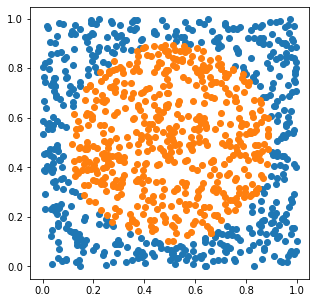

In [62]:
# best result so far with the classeles 2000 epochs 0.999 momentum and  eta 0.0005

plt.figure(figsize=(5, 5))
plt.scatter(test_scatter_false[:,0], test_scatter_false[:,1], )
plt.scatter(test_scatter_true[:,0], test_scatter_true[:,1], )